[View in Colaboratory](https://colab.research.google.com/github/nikete/beats/blob/master/Thesis_Simulations.ipynb)

# Data Preparation 
Data can be dowloaded from https://datashare.is.ed.ac.uk/bitstream/handle/10283/128/IST_corrected.csv?sequence=5&isAllowed=y 
The article and description is at http://www.trialsjournal.com/content/12/1/101/


In [7]:
!pip install -U -q PyDrive 
!pip install wget

import os, wget


import pandas as pd
url = 'https://datashare.is.ed.ac.uk/bitstream/handle/10283/128/IST_corrected.csv'

fname = wget.download(url)

file_ = open(fname, 'r', errors='replace')
#stroke =  pd.read_csv("data/IST_data.csv", true_values='Y', false_values='N', na_values='U', skipinitialspace=True,low_memory=False)
#stroke.dropna(inplace=True,subset=['CMPLASP'])
#stroke.dropna(inplace=True,subset=['CMPLHEP'])


stroke_processed = pd.read_csv(file_, low_memory=False) #this mixed type warning if i dont include the low memory, why exactly?

class IST():
    def __init__(self, drug='RXHEP'):
        outcome="SET14D"
        stroke = stroke_processed[np.isfinite(stroke_processed[outcome])]
        self.arm_id = list(stroke_processed[drug].unique())
        random.shuffle(self.arm_id) #assign random index to each arm, so bugs that prefer a index cant help
        #self.arms = [stroke[stroke[drug] == arm][['actual'+drug,outcome]].values for arm in self.arm_id] doesnt run
        self.arms = [stroke[stroke[drug] == arm][[drug,outcome]].values for arm in self.arm_id] #runs but dunno if correct index, dunno where original line came from
        self.arm_samples = [len(a) for a in self.arms]
    def draw_subject(self):
        r= [ random.randint(0,h) for h in self.arm_samples]
        return [(self.arm_id.index(self.arms[i][rr][0]),self.arms[i][rr][1]) for i,rr in enumerate(r)]


In [8]:
!pip install -q scipy pymc scikits.bootstrap numba cython


#REPLACE
#from scipy import stats
#from pymc import rbeta

%reload_ext autoreload
%autoreload 2

from multiprocessing import Pool

from IPython.display import display, HTML

from IPython.display import clear_output



import numpy as np

from numpy import random

import scikits.bootstrap as boot


import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline  

import math
from __future__ import division
import pprint

import numba # we need the very latest numba to do this with jit classes, TODO later
import Cython
import sys
print(sys.version_info)
from matplotlib import pyplot
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

#from collections import deque 

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)


In [9]:
#utility functions

def ci(v):
    cie= boot.ci( v, np.mean )
    return cie[0],cie[1]

def display_results(r):
    display(r.groupby(["drug","base bandit"]).agg([ np.mean, np.median, np.min, np.max, np.std, ci]))
    display(r.groupby(["drug","high estimator"]).agg([np.mean,np.median,np.min, np.max, np.std, ci]))
    display(r.groupby(["drug","high estimator","base bandit"]).agg([ np.mean,np.median, np.min, np.max, np.std, ci]))
    display(r.groupby(["high estimator","base bandit"]).agg([ np.mean,np.median, np.min, np.max, np.std, ci]))
    pyplot.show()

@numba.jit(nopython=True)
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

@numba.jit(nopython=True)
def potentials_to_probs(x):
  return sigmoid(x)/sigmoid(x).sum()

@numba.jit(nopython=True)
def online_mean(old,v,n):
    return ((n - 1) / float(n)) * old + (1 / float(n)) * v

@numba.jit(nopython=True)
def decay_avg(old,v,n, g=0):
    return ((n - (1+g)) / float(n)) * old + ((1+g) / float(n)) * v
    # tune g online to achieve good prediction of conditional reward given chosen action

@numba.jit(nopython=True)
def stochastic_argmax(x):
    """returns the index of a max value, if there are multiple, picks one uniformly at random"""
    #  cleaner but cant numba: return np.random.choice(np.where( x >= x[x.argmax()] )[0])
    candidates = np.where( x >= x[x.argmax()] )[0]
    return ( candidates[np.random.randint(0,len(candidates))])

#much faster than np.random.choice ?
@numba.jit(nopython=True)
def categorical_draw(probs):
  z = random.random()
  cum_prob = 0.0
  for i in range(probs.shape[0]):
    cum_prob += probs[i]
    if cum_prob > z: return i
  return probs.shape[0] - 1



@numba.jit(nopython=True)
def beta(svec,fvec):
    v = np.zeros(svec.shape[0])
    for i in range(svec.shape[0]):
        v[i] = random.beta(svec[i],fvec[i])
    return v




In [10]:
class Bandit(object):
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.values = np.ones(n_arms,dtype=np.float64)
        self.counts = np.ones(n_arms, dtype=np.float64)
    def update_reward(self, chosen_arm, reward, probability=1):
        #reward= 1/probability
        self.counts[chosen_arm] += 1
        self.values[chosen_arm] = online_mean(self.values[chosen_arm],reward,self.counts[chosen_arm])


class RandomBandit(Bandit):
    def select_arm(self):
        return int(random.random()*self.n_arms)

class ThompsonBeta():
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.sucess = np.zeros(n_arms,dtype=np.float64)
        self.failures = np.zeros(n_arms, dtype=np.float64)
    def update_reward(self, chosen_arm, reward, probability=1):
        if reward == 1:self.sucess[chosen_arm] += 1/probability 
        else: self.failures[chosen_arm] += 1/probability
    def select_arm(self):
        return stochastic_argmax( beta(1 + self.sucess, 1 + self.failures) ) #uniform prior, for  jeffreys prior do 0.5 instead of 1
    def get_probs(self):
        return (1 + self.sucess )/( 2 + self.failures  + self.sucess )
    
class Softmax(Bandit):
    def select_arm(self):
        t = sum(self.counts) + 1
        temperature = 1 / math.log(t + 0.0000001) # or 0.1
        mv = np.max(self.values)
        z =  np.sum(np.exp((self.values-mv) / temperature))
        probs = np.exp((self.values-mv) / temperature) / z
        return categorical_draw(probs)

class EpsilonGreedy(Bandit):
    def select_arm(self):
        t = sum(self.counts) + 1
        epsilon = 1 / math.log(t + 0.0000001) # or jus 0.1
        if random.random() > epsilon: return stochastic_argmax(self.values)
        else: return random.randint(self.n_arms)


class UCB1(Bandit):
    def select_arm(self):
        if np.min(self.counts) == 0:
            chosen_arm = np.argmin(self.counts)
        else:
            ucb_values = np.zeros(self.n_arms)
            total_counts = np.sum(self.counts)
            for arm in range(self.n_arms):
                ucb_values[arm] = self.values[arm] + math.sqrt((2 * np.log(total_counts)) / self.counts[arm])
            chosen_arm = stochastic_argmax(ucb_values)
        return chosen_arm


class Exp3V():
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.weights = np.ones(n_arms, dtype=np.float64)
        self.probs = np.ones(n_arms, dtype=np.float64)
    def select_arm(self):
        return categorical_draw(self.probs)
    def get_probs(self):
        return self.probs
    def update_reward(self, chosen_arm, reward, probability=1):
        gamma=0.0085 #0.0085 seems to have come from the bound optimized parameters, but how?
        reward= reward/probability
        total_weight = np.sum(self.weights)
        self.weights[chosen_arm] = self.weights[chosen_arm] * np.exp((gamma) * (reward / self.probs[chosen_arm]))
        self.probs = self.weights / np.sum(self.weights)



# Build Compliance Aware Bandits and baselines

In [11]:

def make_derivative_bandits(base_algos):
    resulting_algos=[]
    for b in base_algos:
        class chosen(b):
            def update(self, chosen, actual,reward): 
                self.update_reward(chosen,reward)
        resulting_algos.append(chosen)

        class actual(b):
            def update(self, chosen, actual,reward): 
                self.update_reward(actual,reward)
        resulting_algos.append(actual)

        class comply_only(b):
            def update(self, chosen_arm, actual_arm,reward): 
                if chosen_arm == actual_arm:
                    self.update_reward( actual_arm,reward)
        resulting_algos.append(comply_only)

        class DoubleBanditRecycle():
            def __init__(self, n_arms, base_algo=b,higher_algo=Exp3V):#b
                self.n_arms = n_arms
                self.low_bandits = [base_algo(n_arms),base_algo(n_arms),base_algo(n_arms)]
                self.high_bandit = higher_algo(len(self.low_bandits)) 
                self.prev_high_chosen = []
                self.unused_samples = [[] for i in range(n_arms)]

            def update(self, chosen, actual, reward):
                if self.prev_high_chosen[0] == 0: self.low_bandits[0].update_reward(chosen,reward,self.high_bandit.get_probs()[0]) # asimptotically good no matter what
                else: self.unused_samples[chosen].append(reward)
                self.low_bandits[1].update_reward(actual,reward) # finite sample better when noncmopliance indepedent of rewards
                if chosen==actual: self.low_bandits[2].update_reward(chosen,reward)# good when noncompliers have different distribution of rewards than compliers
                self.high_bandit.update_reward(self.prev_high_chosen[0],reward)
                    
            def select_arm(self):
                choices = [self.low_bandits[i].select_arm() for i in range(len(self.low_bandits))]
                self.prev_high_chosen =[self.high_bandit.select_arm()] # [i for i, v in enumerate(choices) if v == chosen]
                if self.prev_high_chosen[0] != 0: #it is not normally when chosen would play
                    if min([len(a) for a in self.unused_samples]) > 0: #but we can still give it feedback, becuase we chose this before, so know how it woudl work out (IID)
                        reward= self.unused_samples[choices[0]].pop()
                        self.low_bandits[0].update_reward(choices[0],reward, self.high_bandit.get_probs()[0])
                return  choices[self.prev_high_chosen[0]]
        resulting_algos.append(DoubleBanditRecycle)

     
        
        class ThompsonBounded():#with recycle
            def __init__(self, n_arms, base_algo=b,higher_algo=ThompsonBeta):#b
                self.n_arms = n_arms
                self.chosen_bounding = ThompsonBeta(n_arms)
                self.low_bandits = [base_algo(n_arms)]
                self.prev_bound_used = True
                self.unused_samples = [[] for i in range(n_arms)]

            def update(self, chosen, actual, reward):
                if self.prev_bound_used:
                    self.chosen_bounding.update_reward(chosen,reward, sum(self.chosen_bounding.get_probs()**2) )
                else: 
                    self.unused_samples[chosen].append(reward)
                self.low_bandits[0].update_reward(actual,reward) # finite sample better when noncmopliance indepedent of rewards

            def select_arm(self): #aethetic of the while
                choices = [self.low_bandits[0].select_arm()]
                if (self.chosen_bounding.select_arm() == self.chosen_bounding.select_arm()):
                    bound_chose = self.chosen_bounding.select_arm()
                    if min([len(a) for a in self.unused_samples]) > 0: #but we can still give it feedback, becuase we chose this before, so know how it woudl work out (IID)
                        # use that to feed and continue since we can preserve the bound without taking away from the uncert base
                        reward= self.unused_samples[bound_chose].pop()
                        self.chosen_bounding.update_reward(bound_chose,reward, sum(self.chosen_bounding.get_probs()**2) )    
                    else:
                        self.prev_bound_used = True
                        return bound_chose #doesnt matter whic one we use, by construction, so we use 0
                self.prev_bound_used = False
                return choices[0]

   
        resulting_algos.append(ThompsonBounded)
    return resulting_algos

all_algos=make_derivative_bandits([EpsilonGreedy,UCB1,ThompsonBeta])
base_name = ["EpsilonGreedy","UCB1","ThompsonBeta"]
high_name = ["chosen","actual","comply","HB","TB"]


# Simulation Code

In [12]:


def sim(drug, DGP=IST ,nsim=10, T=10001, steps=10, extra=0):
    columns=['base bandit','high estimator',"surplus",'drug','t']
    results = pd.DataFrame(np.zeros((nsim*steps*len(all_algos)+extra, len(columns))), columns=columns) #hardcodes 20 algos*baselines, nasty
    counter=0
    for index, s in enumerate(range(nsim)):
        dgp=DGP(drug)
        k = len(dgp.draw_subject())
        rewards=np.zeros(len(all_algos))
        bandit_instances = [b(k) for b in all_algos]
        mean_rewards = 0
        for t in range(T):
            r = dgp.draw_subject()
            mean_rewards += np.sum([v/k for a,v in r])
            for i,a in enumerate(bandit_instances): 
                chosen = int(a.select_arm())
                actual,reward = r[chosen]
                a.update(chosen,actual,reward)
                rewards[i]+= reward
            if (t%int(T/steps) == 0) and (t>0):
                for i in range(len(all_algos)):
                    try:
                        results.iloc[counter] = pd.Series( {
                                             'base bandit':base_name[i//len(high_name)] , 
                                             'high estimator':high_name[i%len(high_name)],
                                             'surplus':rewards[i] - mean_rewards ,
                                             'drug':drug,
                                             't':t})
                    except (IndexError):
                        results.append(pd.Series( {
                                             'base bandit':base_name[i//len(high_name)] , 
                                             'high estimator':high_name[i%len(high_name)],
                                             'surplus':rewards[i] - mean_rewards ,
                                             'drug':drug,
                                             't':t}), ignore_index = True)
                    counter+=1
    return results



In [13]:
import time


In [0]:
inputs = ["RXASP","RXHEP"]*2
results = pd.DataFrame(columns=['base bandit','high estimator',"surplus",'drug','t'])
for x in range(25):
    t = time.time()
    with Pool(4) as p: #how many cores do we wan to use
        partial_results=(p.map(sim, inputs))
    for p in partial_results:
        results = pd.concat([p,results] )
    elapsed_time = time.time() - t
    print(elapsed_time)

#had been 13s for 1. 75 for 10, 725 for 100, 8943 for 1000, 10k becomes silly again


In [0]:
g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=results,
                   size=6, palette="muted", row="base bandit") #
g.despine(left=True)
g.set_ylabels("lives saved")
g.savefig("Fig1-thesis-sim.png")
g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=results,
                   size=6, palette="muted", row="drug",col="base bandit") #
g.despine(left=True)
g.set_ylabels("lives saved")
g.savefig("by_drug_appendix-thesis-sim.png")


In [0]:
sns.barplot(x='t', y="surplus", hue="high estimator", data=results[results['drug'].str.contains("RXASP")],
                   palette="muted")

NameError: ignored

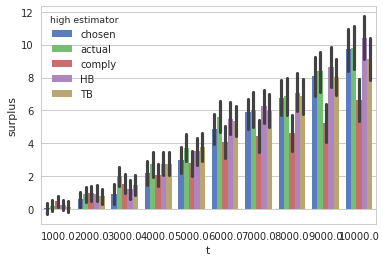

In [0]:
sns.barplot(x='t', y="surplus", hue="high estimator", data=results[results['drug'].str.contains("RXHEP")],
                   palette="muted")

In [0]:
display_results(results.loc[results['t'] == 10000].drop('t',1))
display_results(results.loc[results['t'] == 10000])

results.to_csv('simulation1.csv')

surplus                                               \
                          mean     median       amin        amax        std   
drug  base bandit                                                             
RXASP EpsilonGreedy   7.256400  12.000000 -64.500000   65.000000  22.443162   
      Exp3V          -4.966400  -5.500000 -69.500000   81.500000  21.462426   
      ThompsonBeta    9.639200  12.500000 -68.000000   71.000000  21.134793   
      UCB1            0.644400  -1.000000 -60.000000   67.000000  20.240188   
RXHEP EpsilonGreedy  16.593467  19.333333 -97.333333   99.333333  34.523675   
      Exp3V          -3.376133  -3.333333 -92.333333   91.000000  26.122994   
      ThompsonBeta   16.802667  18.666667 -87.000000  100.333333  28.453266   
      UCB1            5.934667   6.666667 -94.666667   87.666667  24.975495   

                                                                
                                                            ci  
drug  base bandit                                               
RXASP EpsilonGreedy                           (6.3444, 8.1256)  
      Exp3V                                 (-5.7892, -4.1272)  
      ThompsonBeta                           (8.8088, 10.4404)  
      UCB1                                    (-0.162, 1.4528)  
RXHEP EpsilonGreedy   (15.241333333235174, 17.959999999901623)  
      Exp3V          (-4.373333333431804, -2.3694666667648256)  
      ThompsonBeta     (15.702133333234652, 17.91853333323506)  
      UCB1             (4.948266666568351, 6.8923999999017225)

surplus                                               \
                           mean     median       amin        amax        std   
drug  high estimator                                                           
RXASP HB               4.973000   7.000000 -66.500000   81.500000  21.776315   
      TB               3.900500   5.500000 -61.000000   71.000000  21.955594   
      actual           5.318000   6.500000 -69.500000   66.500000  20.767210   
      chosen           0.650000   2.000000 -64.500000   65.000000  23.289197   
      comply           0.875500   1.000000 -68.000000   55.500000  22.138712   
RXHEP HB              10.671167  10.666667 -94.666667   99.333333  29.689281   
      TB               8.452167   8.000000 -91.666667   91.000000  28.755246   
      actual           8.600667   7.333333 -91.666667   95.333333  31.349752   
      chosen           9.457667   9.333333 -86.333333   95.666667  29.497654   
      comply           7.761667   9.333333 -97.333333  100.333333  30.336661   

                                                               
                                                           ci  
drug  high estimator                                           
RXASP HB                                   (4.04575, 5.93475)  
      TB                                    (2.91475, 4.8515)  
      actual                               (4.39425, 6.22025)  
      chosen                              (-0.38275, 1.66325)  
      comply                                  (-0.094, 1.859)  
RXHEP HB                (9.339166666568184, 11.9604999999017)  
      TB               (7.197666666567886, 9.704999999901382)  
      actual           (7.250999999901111, 9.970333333234791)  
      chosen          (8.219166666568096, 10.769499999901706)  
      comply           (6.421499999901654, 9.084999999901544)

surplus                        \
                                         mean     median       amin   
drug  high estimator base bandit                                      
RXASP HB             EpsilonGreedy   8.032000  10.500000 -58.500000   
                     Exp3V           0.420000   0.750000 -59.000000   
                     ThompsonBeta    9.954000  13.000000 -66.500000   
                     UCB1            1.486000   2.500000 -60.000000   
      TB             EpsilonGreedy   7.482000   9.000000 -51.500000   
                     Exp3V          -3.124000  -2.500000 -61.000000   
                     ThompsonBeta    8.620000  11.500000 -56.000000   
                     UCB1            2.624000   3.000000 -55.000000   
      actual         EpsilonGreedy  13.858000  16.500000 -37.000000   
                     Exp3V         -10.524000 -11.250000 -69.500000   
                     ThompsonBeta   15.288000  17.000000 -56.500000   
                     UCB1            2.650000  -0.500000 -40.000000   
      chosen         EpsilonGreedy  -1.060000   4.000000 -62.000000   
                     Exp3V           1.714000   3.000000 -64.500000   
                     ThompsonBeta    3.814000   6.250000 -64.500000   
                     UCB1           -1.868000  -3.750000 -56.000000   
      comply         EpsilonGreedy   7.970000  13.500000 -64.500000   
                     Exp3V         -13.318000 -14.250000 -67.500000   
                     ThompsonBeta   10.520000  12.000000 -68.000000   
                     UCB1           -1.670000  -6.000000 -37.000000   
RXHEP HB             EpsilonGreedy  15.976667  19.333333 -85.000000   
                     Exp3V           2.922667   3.666667 -83.666667   
                     ThompsonBeta   16.842667  17.000000 -69.333333   
                     UCB1            6.942667   7.666667 -94.666667   
      TB             EpsilonGreedy  13.808667  14.333333 -91.666667   
                     Exp3V          -2.775333  -3.666667 -71.666667   
                     ThompsonBeta   15.172667  17.000000 -87.000000   
                     UCB1            7.602667   8.166667 -86.000000   
      actual         EpsilonGreedy  22.340667  25.333333 -69.333333   
                     Exp3V         -10.033333  -9.833333 -91.666667   
                     ThompsonBeta   17.440667  20.666667 -80.666667   
                     UCB1            4.654667   5.000000 -72.333333   
      chosen         EpsilonGreedy  13.970667  15.500000 -86.333333   
                     Exp3V           2.624667   3.833333 -69.666667   
                     ThompsonBeta   16.478667  18.333333 -80.333333   
                     UCB1            4.756667   5.000000 -58.333333   
      comply         EpsilonGreedy  16.870667  23.333333 -97.333333   
                     Exp3V          -9.619333  -8.500000 -92.333333   
                     ThompsonBeta   18.078667  19.333333 -82.000000   
                     UCB1            5.716667   6.000000 -71.666667   

                                                           \
                                          amax        std   
drug  high estimator base bandit                            
RXASP HB             EpsilonGreedy   63.500000  21.906249   
                     Exp3V           81.500000  22.166039   
                     ThompsonBeta    62.500000  20.553144   
                     UCB1            67.000000  20.948568   
      TB             EpsilonGreedy   59.500000  21.358630   
                     Exp3V           52.000000  20.945335   
                     ThompsonBeta    71.000000  21.577297   
                     UCB1            59.500000  22.008325   
      actual         EpsilonGreedy   52.000000  15.949470   
                     Exp3V           43.000000  20.361621   
                     ThompsonBeta    66.500000  18.229500   
                     UCB1            57.500000  17.179137   
      chosen         EpsilonGreedy   65.000000  26.982058   
        

surplus                                    \
                                   mean     median       amin        amax   
high estimator base bandit                                                  
HB             EpsilonGreedy  12.004333  13.166667 -85.000000   99.333333   
               Exp3V           1.671333   2.333333 -83.666667   88.000000   
               ThompsonBeta   13.398333  14.500000 -69.333333   96.000000   
               UCB1            4.214333   4.500000 -94.666667   67.000000   
TB             EpsilonGreedy  10.645333  11.000000 -91.666667   90.666667   
               Exp3V          -2.949667  -3.000000 -71.666667   91.000000   
               ThompsonBeta   11.896333  13.000000 -87.000000   86.333333   
               UCB1            5.113333   6.666667 -86.000000   87.666667   
actual         EpsilonGreedy  18.099333  18.000000 -69.333333   95.333333   
               Exp3V         -10.278667 -10.583333 -91.666667   66.000000   
               ThompsonBeta   16.364333  18.000000 -80.666667   92.333333   
               UCB1            3.652333   1.833333 -72.333333   74.666667   
chosen         EpsilonGreedy   6.455333  10.000000 -86.333333   95.666667   
               Exp3V           2.169333   3.333333 -69.666667   70.000000   
               ThompsonBeta   10.146333  11.500000 -80.333333   87.666667   
               UCB1            1.444333   0.333333 -58.333333   68.000000   
comply         EpsilonGreedy  12.420333  17.000000 -97.333333   81.333333   
               Exp3V         -11.468667 -12.000000 -92.333333   73.666667   
               ThompsonBeta   14.299333  15.000000 -82.000000  100.333333   
               UCB1            2.023333  -1.500000 -71.666667   65.666667   

                                         \
                                    std   
high estimator base bandit                
HB             EpsilonGreedy  29.265713   
               Exp3V          25.630953   
               ThompsonBeta   25.266729   
               UCB1           22.221905   
TB             EpsilonGreedy  26.073688   
               Exp3V          23.288953   
               ThompsonBeta   25.411674   
               UCB1           25.192578   
actual         EpsilonGreedy  28.516606   
               Exp3V          22.925512   
               ThompsonBeta   23.375282   
               UCB1           20.833402   
chosen         EpsilonGreedy  32.425549   
               Exp3V          23.021145   
               ThompsonBeta   27.110940   
               UCB1           23.202904   
comply         EpsilonGreedy  29.658880   
               Exp3V          21.001744   
               ThompsonBeta   24.877522   
               UCB1           22.582226   

                                                                          
                                                                      ci  
high estimator base bandit                                                
HB             EpsilonGreedy       (10.13583333328398, 13.8429999999495)  
               Exp3V            (0.01099999994969403, 3.230999999949674)  
               ThompsonBeta     (11.817333333283742, 14.940999999952162)  
               UCB1              (2.7869999999517057, 5.551333333278926)  
TB             EpsilonGreedy      (9.04599999995048, 12.283833333283468)  
               Exp3V            (-4.37733333338267, -1.5003333333842983)  
               ThompsonBeta      (10.329666666617188, 13.50016666661705)  
               UCB1               (3.556166666619747, 6.684999999948983)  
actual         EpsilonGreedy      (16.35999999994963, 19.90066666661748)  
               Exp3V           (-11.744166666716174, -8.844666666717673)  
               ThompsonBeta      (14.931499999953994, 17.82666666661783)  
               UCB1              (2.364833333283361, 4.9393333332799685)  
chosen         EpsilonGreedy       (4.458999999951793, 8.49416666661628)  
               Exp3V            (0.7746666666174842, 3.625499999951716

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa 

surplus                                               \
                          mean     median       amin        amax        std   
drug  base bandit                                                             
RXASP EpsilonGreedy   7.256400  12.000000 -64.500000   65.000000  22.443162   
      Exp3V          -4.966400  -5.500000 -69.500000   81.500000  21.462426   
      ThompsonBeta    9.639200  12.500000 -68.000000   71.000000  21.134793   
      UCB1            0.644400  -1.000000 -60.000000   67.000000  20.240188   
RXHEP EpsilonGreedy  16.593467  19.333333 -97.333333   99.333333  34.523675   
      Exp3V          -3.376133  -3.333333 -92.333333   91.000000  26.122994   
      ThompsonBeta   16.802667  18.666667 -87.000000  100.333333  28.453266   
      UCB1            5.934667   6.666667 -94.666667   87.666667  24.975495   

                                                                     t  \
                                                           ci     mean   
drug  base bandit                                                        
RXASP EpsilonGreedy                           (6.372, 8.1336)  10000.0   
      Exp3V                                (-5.7972, -4.1394)  10000.0   
      ThompsonBeta                          (8.8202, 10.4576)  10000.0   
      UCB1                                  (-0.1456, 1.4462)  10000.0   
RXHEP EpsilonGreedy  (15.208799999901556, 17.944666666568132)  10000.0   
      Exp3V            (-4.410800000098529, -2.3506666667647)  10000.0   
      ThompsonBeta   (15.671199999901344, 17.896799999901425)  10000.0   
      UCB1             (4.939866666567796, 6.921866666567699)  10000.0   

                                                                         
                      median     amin     amax  std                  ci  
drug  base bandit                                                        
RXASP EpsilonGreedy  10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      Exp3V          10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      ThompsonBeta   10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      UCB1           10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
RXHEP EpsilonGreedy  10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      Exp3V          10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      ThompsonBeta   10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      UCB1           10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa 

surplus                                               \
                           mean     median       amin        amax        std   
drug  high estimator                                                           
RXASP HB               4.973000   7.000000 -66.500000   81.500000  21.776315   
      TB               3.900500   5.500000 -61.000000   71.000000  21.955594   
      actual           5.318000   6.500000 -69.500000   66.500000  20.767210   
      chosen           0.650000   2.000000 -64.500000   65.000000  23.289197   
      comply           0.875500   1.000000 -68.000000   55.500000  22.138712   
RXHEP HB              10.671167  10.666667 -94.666667   99.333333  29.689281   
      TB               8.452167   8.000000 -91.666667   91.000000  28.755246   
      actual           8.600667   7.333333 -91.666667   95.333333  31.349752   
      chosen           9.457667   9.333333 -86.333333   95.666667  29.497654   
      comply           7.761667   9.333333 -97.333333  100.333333  30.336661   

                                                                     t  \
                                                           ci     mean   
drug  high estimator                                                     
RXASP HB                                     (4.0065, 5.9105)  10000.0   
      TB                                    (2.93125, 4.8635)  10000.0   
      actual                                (4.42225, 6.2125)  10000.0   
      chosen                                (-0.36525, 1.664)  10000.0   
      comply                                 (-0.1155, 1.823)  10000.0   
RXHEP HB              (9.334666666567635, 11.969999999901484)  10000.0   
      TB               (7.182999999901568, 9.729833333235092)  10000.0   
      actual           (7.222333333235093, 9.968999999901223)  10000.0   
      chosen          (8.142166666568183, 10.724666666568083)  10000.0   
      comply           (6.435166666568352, 9.063499999901884)  10000.0   

                                                                          
                       median     amin     amax  std                  ci  
drug  high estimator                                                      
RXASP HB              10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      TB              10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      actual          10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      chosen          10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      comply          10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
RXHEP HB              10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      TB              10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      actual          10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      chosen          10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)  
      comply          10000.0  10000.0  10000.0  0.0  (10000.0, 10000.0)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.


surplus                        \
                                         mean     median       amin   
drug  high estimator base bandit                                      
RXASP HB             EpsilonGreedy   8.032000  10.500000 -58.500000   
                     Exp3V           0.420000   0.750000 -59.000000   
                     ThompsonBeta    9.954000  13.000000 -66.500000   
                     UCB1            1.486000   2.500000 -60.000000   
      TB             EpsilonGreedy   7.482000   9.000000 -51.500000   
                     Exp3V          -3.124000  -2.500000 -61.000000   
                     ThompsonBeta    8.620000  11.500000 -56.000000   
                     UCB1            2.624000   3.000000 -55.000000   
      actual         EpsilonGreedy  13.858000  16.500000 -37.000000   
                     Exp3V         -10.524000 -11.250000 -69.500000   
                     ThompsonBeta   15.288000  17.000000 -56.500000   
                     UCB1            2.650000  -0.500000 -40.000000   
      chosen         EpsilonGreedy  -1.060000   4.000000 -62.000000   
                     Exp3V           1.714000   3.000000 -64.500000   
                     ThompsonBeta    3.814000   6.250000 -64.500000   
                     UCB1           -1.868000  -3.750000 -56.000000   
      comply         EpsilonGreedy   7.970000  13.500000 -64.500000   
                     Exp3V         -13.318000 -14.250000 -67.500000   
                     ThompsonBeta   10.520000  12.000000 -68.000000   
                     UCB1           -1.670000  -6.000000 -37.000000   
RXHEP HB             EpsilonGreedy  15.976667  19.333333 -85.000000   
                     Exp3V           2.922667   3.666667 -83.666667   
                     ThompsonBeta   16.842667  17.000000 -69.333333   
                     UCB1            6.942667   7.666667 -94.666667   
      TB             EpsilonGreedy  13.808667  14.333333 -91.666667   
                     Exp3V          -2.775333  -3.666667 -71.666667   
                     ThompsonBeta   15.172667  17.000000 -87.000000   
                     UCB1            7.602667   8.166667 -86.000000   
      actual         EpsilonGreedy  22.340667  25.333333 -69.333333   
                     Exp3V         -10.033333  -9.833333 -91.666667   
                     ThompsonBeta   17.440667  20.666667 -80.666667   
                     UCB1            4.654667   5.000000 -72.333333   
      chosen         EpsilonGreedy  13.970667  15.500000 -86.333333   
                     Exp3V           2.624667   3.833333 -69.666667   
                     ThompsonBeta   16.478667  18.333333 -80.333333   
                     UCB1            4.756667   5.000000 -58.333333   
      comply         EpsilonGreedy  16.870667  23.333333 -97.333333   
                     Exp3V          -9.619333  -8.500000 -92.333333   
                     ThompsonBeta   18.078667  19.333333 -82.000000   
                     UCB1            5.716667   6.000000 -71.666667   

                                                           \
                                          amax        std   
drug  high estimator base bandit                            
RXASP HB             EpsilonGreedy   63.500000  21.906249   
                     Exp3V           81.500000  22.166039   
                     ThompsonBeta    62.500000  20.553144   
                     UCB1            67.000000  20.948568   
      TB             EpsilonGreedy   59.500000  21.358630   
                     Exp3V           52.000000  20.945335   
                     ThompsonBeta    71.000000  21.577297   
                     UCB1            59.500000  22.008325   
      actual         EpsilonGreedy   52.000000  15.949470   
                     Exp3V           43.000000  20.361621   
                     ThompsonBeta    66.500000  18.229500   
                     UCB1            57.500000  17.179137   
      chosen         EpsilonGreedy   65.000000  26.982058   
        

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  after removing the cwd from sys.path.


surplus                                    \
                                   mean     median       amin        amax   
high estimator base bandit                                                  
HB             EpsilonGreedy  12.004333  13.166667 -85.000000   99.333333   
               Exp3V           1.671333   2.333333 -83.666667   88.000000   
               ThompsonBeta   13.398333  14.500000 -69.333333   96.000000   
               UCB1            4.214333   4.500000 -94.666667   67.000000   
TB             EpsilonGreedy  10.645333  11.000000 -91.666667   90.666667   
               Exp3V          -2.949667  -3.000000 -71.666667   91.000000   
               ThompsonBeta   11.896333  13.000000 -87.000000   86.333333   
               UCB1            5.113333   6.666667 -86.000000   87.666667   
actual         EpsilonGreedy  18.099333  18.000000 -69.333333   95.333333   
               Exp3V         -10.278667 -10.583333 -91.666667   66.000000   
               ThompsonBeta   16.364333  18.000000 -80.666667   92.333333   
               UCB1            3.652333   1.833333 -72.333333   74.666667   
chosen         EpsilonGreedy   6.455333  10.000000 -86.333333   95.666667   
               Exp3V           2.169333   3.333333 -69.666667   70.000000   
               ThompsonBeta   10.146333  11.500000 -80.333333   87.666667   
               UCB1            1.444333   0.333333 -58.333333   68.000000   
comply         EpsilonGreedy  12.420333  17.000000 -97.333333   81.333333   
               Exp3V         -11.468667 -12.000000 -92.333333   73.666667   
               ThompsonBeta   14.299333  15.000000 -82.000000  100.333333   
               UCB1            2.023333  -1.500000 -71.666667   65.666667   

                                         \
                                    std   
high estimator base bandit                
HB             EpsilonGreedy  29.265713   
               Exp3V          25.630953   
               ThompsonBeta   25.266729   
               UCB1           22.221905   
TB             EpsilonGreedy  26.073688   
               Exp3V          23.288953   
               ThompsonBeta   25.411674   
               UCB1           25.192578   
actual         EpsilonGreedy  28.516606   
               Exp3V          22.925512   
               ThompsonBeta   23.375282   
               UCB1           20.833402   
chosen         EpsilonGreedy  32.425549   
               Exp3V          23.021145   
               ThompsonBeta   27.110940   
               UCB1           23.202904   
comply         EpsilonGreedy  29.658880   
               Exp3V          21.001744   
               ThompsonBeta   24.877522   
               UCB1           22.582226   

                                                                           \
                                                                       ci   
high estimator base bandit                                                  
HB             EpsilonGreedy     (10.155499999951198, 13.773499999952078)   
               Exp3V            (0.10133333328651498, 3.3008333332849396)   
               ThompsonBeta      (11.874833333284629, 14.974333333283715)   
               UCB1               (2.8183333332833755, 5.614666666618594)   
TB             EpsilonGreedy      (9.051333333282985, 12.217499999947592)   
               Exp3V            (-4.415500000047566, -1.5265000000531728)   
               ThompsonBeta      (10.282333333285385, 13.476833333283293)   
               UCB1               (3.5509999999515838, 6.686166666620124)   
actual         EpsilonGreedy      (16.396833333283688, 19.87666666661638)   
               Exp3V            (-11.705000000049697, -8.829166666716569)   
               ThompsonBeta       (14.918333333283615, 17.78033333328471)   
               UCB1                (2.3756666666184536, 4.98316666661766)   
chosen         EpsilonGreedy       (4.443833333284678, 8.551333333285479)   
               Exp3V             (0.73

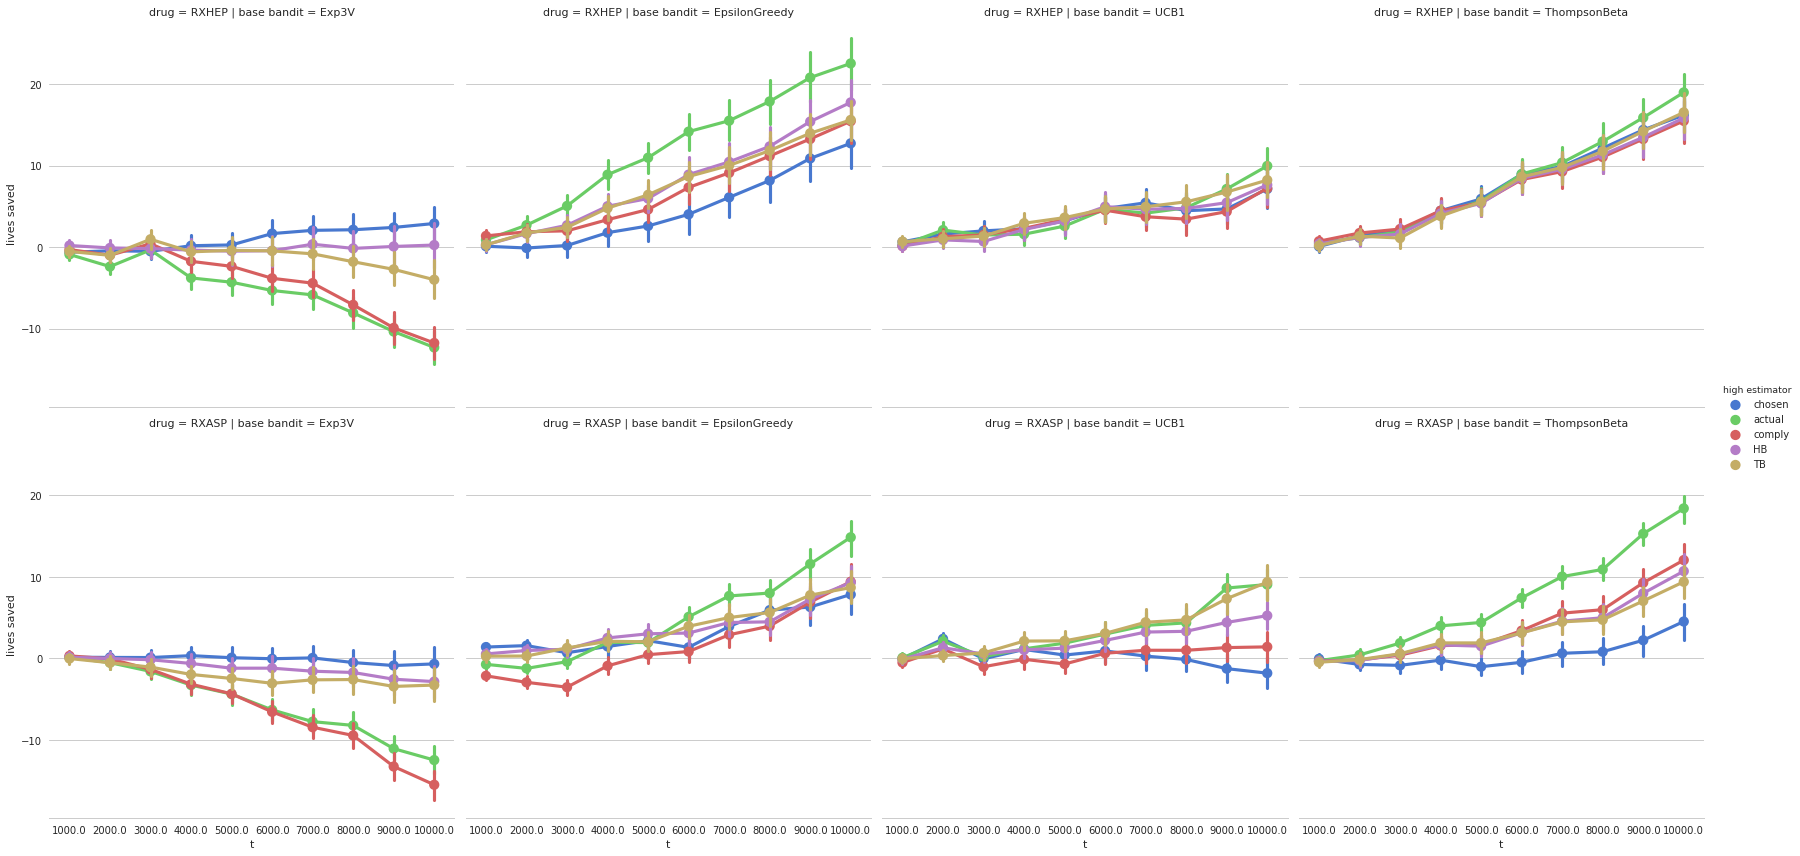

In [0]:


g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=results,
                   size=6, palette="muted", row="drug",col="base bandit") #
g.despine(left=True)
g.set_ylabels("lives saved")
g.savefig("figs/fig1.png")


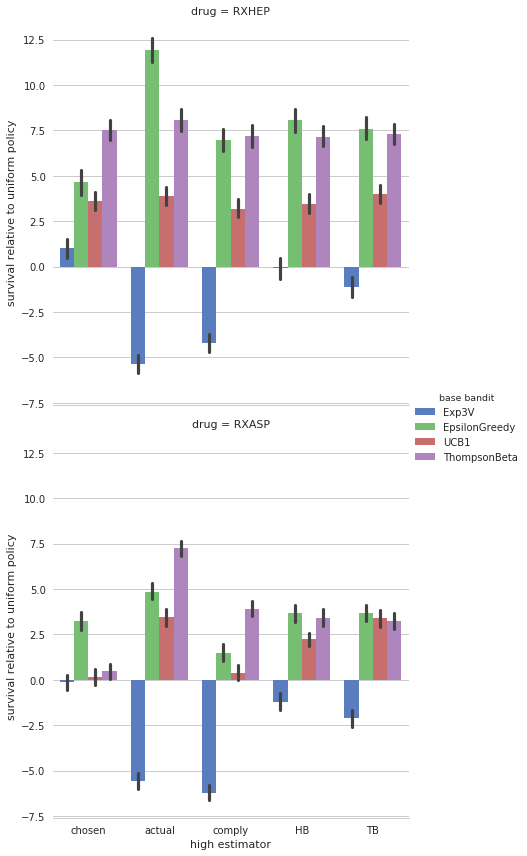

In [0]:
g = sns.factorplot(x='high estimator', y="surplus", hue="base bandit", data=results,
                   size=6, palette="muted", row="drug", kind="bar") #
g.despine(left=True)
g.set_ylabels("survival relative to uniform policy")
g.savefig("figs/Fig1.png")


# results.groupby(["drug","high estimator"]).agg([np.mean,np.median,np.min, np.max, np.std, ci]).to_latex()


#results.groupby(["drug","high estimator","base bandit"]).agg([ np.mean,np.median, np.min, np.max, np.std, ci])

In [0]:


# 2(Linear regret; harmful treatment).Suppose there are two sub-populations: the first consists ofrich,
#healthy patients who always take the treatment. 
#Thesecond consists of poor,less healthy patients who only takethe treatment if prescribed. 
# Finally, suppose the treatmentreduceswellbeing by0:25on some metric.
class ExampleTwo():
    def __init__(self,foo):
        self.n_arms = 2
    def draw_subject(self):
        if random.random() > 0.5: user_type = "rich"
        else: user_type = "poor"

        if user_type == "rich":
             # if they didnt take it they would all do well, but they all take it so only 0.75 chance 
            outcome = random.binomial(1,0.75)
            r=[(1, outcome) for i in range(self.n_arms)] 
        else: #poor, they only take them if told, which brings them down from 0.5 chance to 0.75  
            reward = [random.binomial(1,0.5),random.binomial(1,0.25)] 
            r= [(i, reward[i]) for i in range(self.n_arms)]
        return r
    
#example2 = sim( nsim=1000, T=12, DGP=ExampleTwo , drug="example 2")



2.1584513187408447s, done: 0
2.136321544647217s, done: 1
2.1387760639190674s, done: 2
2.129514455795288s, done: 3
2.149423360824585s, done: 4
2.135478973388672s, done: 5
2.1304030418395996s, done: 6
2.144803285598755s, done: 7
2.1592111587524414s, done: 8
2.15216064453125s, done: 9
2.136643886566162s, done: 10
2.134474992752075s, done: 11
2.150601863861084s, done: 12
2.1379599571228027s, done: 13
2.135047197341919s, done: 14
2.1314237117767334s, done: 15
2.1353814601898193s, done: 16
2.132398843765259s, done: 17
2.135286808013916s, done: 18
2.1348445415496826s, done: 19
2.1666419506073s, done: 20
2.128018379211426s, done: 21
2.139366626739502s, done: 22
2.1584670543670654s, done: 23
2.158594846725464s, done: 24
2.158933162689209s, done: 25
2.1477832794189453s, done: 26
2.167461395263672s, done: 27
2.1508443355560303s, done: 28
2.1593844890594482s, done: 29
2.1558713912963867s, done: 30
2.1586010456085205s, done: 31
2.1556010246276855s, done: 32
2.152900457382202s, done: 33
2.1546533107

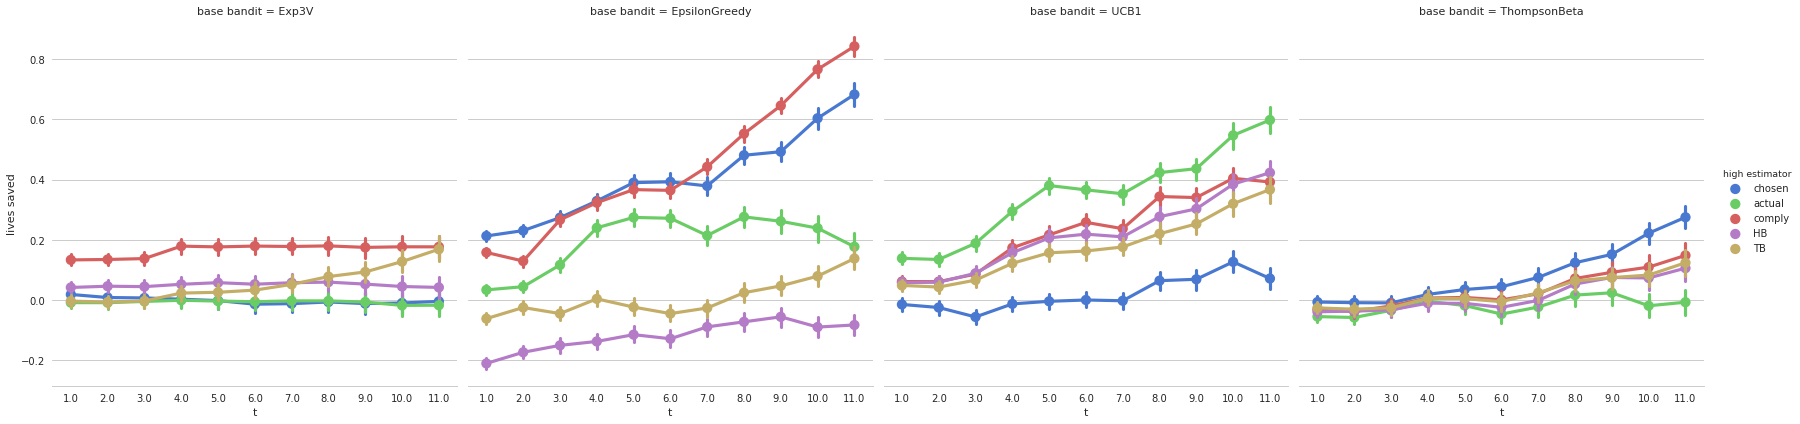

In [0]:
example2 = pd.DataFrame(columns=['base bandit','high estimator',"surplus",'drug','t'])
def sim_wrap1(x):
    return sim( nsim=10, T=12, DGP=ExampleTwo , drug="example 2", extra=200)
for x in range(250):
    with Pool(4) as p: #how many cores do we wan to use
        t0 = time.time()
        partial_results=(p.map(sim_wrap1,[1]))
        t1 = time.time()
        print('{}s, done: {}'.format(t1-t0, x))
    for p in partial_results:
        example2 = pd.concat([p,example2] )
        
        
open('tables/ex2.tex', 'w').write( example2.groupby(["high estimator","base bandit"]).agg([np.mean,np.median,np.min, np.max, np.std, ci]).to_latex() )

g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=example2,
                   size=6, palette="muted", col="base bandit") #
g.despine(left=True)
g.set_ylabels("lives saved")
g.savefig("figs/ex2T12.png")


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


35.397355794906616s, done: 0
35.10316848754883s, done: 1
35.22536897659302s, done: 2


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


35.2725465297699s, done: 3


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


35.187466859817505s, done: 4
35.43376326560974s, done: 5


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


35.47129011154175s, done: 6
35.64341402053833s, done: 7


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


35.3408317565918s, done: 8
35.76542949676514s, done: 9


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


35.44710564613342s, done: 10


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


35.187482833862305s, done: 11


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


35.18631386756897s, done: 12


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


35.52046799659729s, done: 13


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


35.398024797439575s, done: 14


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


35.41035842895508s, done: 15
38.274563789367676s, done: 16


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


35.72779679298401s, done: 17


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


35.13896632194519s, done: 18
35.67600059509277s, done: 19
35.32645773887634s, done: 20
35.48966670036316s, done: 21
35.50593543052673s, done: 22


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


34.99641704559326s, done: 23


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


35.32693862915039s, done: 24


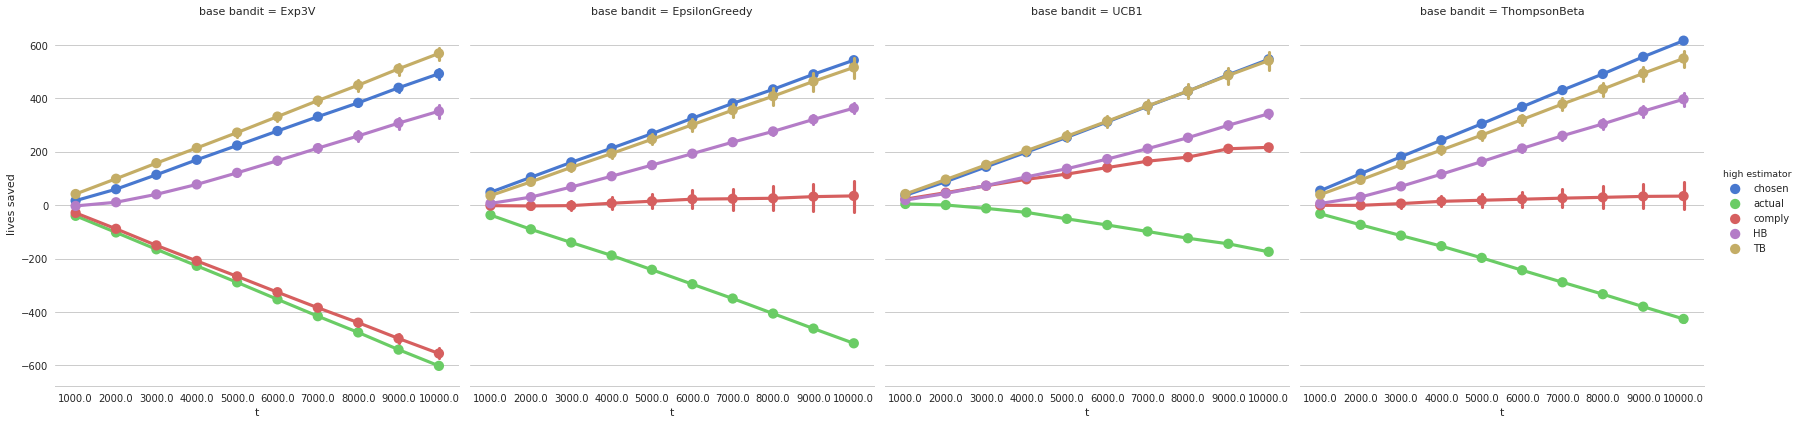

In [0]:
example2b = pd.DataFrame(columns=['base bandit','high estimator',"surplus",'drug','t'])
def sim_wrap2(x):
    return sim( nsim=10, T=10001, DGP=ExampleTwo , drug="example 2")
for x in range(25):
    with Pool(4) as p: #how many cores do we wan to use
        t0 = time.time()
        partial_results=(p.map(sim_wrap2,[1]))
        t1 = time.time()
        print('{}s, done: {}'.format(t1-t0, x))
    for p in partial_results:
        example2b = pd.concat([p,example2b] )

open('tables/ex2b.tex', 'w').write( example2b.groupby(["high estimator","base bandit"]).agg([np.mean,np.median,np.min, np.max, np.std, ci]).to_latex() )

g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=example2b,
                   size=6, palette="muted", col="base bandit") #
g.despine(left=True)
g.set_ylabels("lives saved")
g.savefig("figs/ex2T10000png")


In [0]:
class NoncomplianceForBestArm():
    def __init__(self,foo ):
        n_arms=2
        self.arm_value = np.random.random(n_arms)#0.5+0.25*
        self.n_arms = n_arms
    def draw_subject(self):
        prefered_arm = stochastic_argmax(self.arm_value)
        prefered_reward = random.binomial(1,self.arm_value[prefered_arm])
        r = []
        for i in range(self.n_arms):
            if self.arm_value[i] / self.arm_value[prefered_arm] < random.random(): #informative noncompliance
                r.append((prefered_arm,prefered_reward))
            else:  #compliers 
                r.append((i,  random.binomial(1,self.arm_value[i])))
        return r
def sim_wrap4(x):
    return sim( nsim=10, T=12, DGP=NoncomplianceForBestArm, extra=200 , drug="Better arm")
#display_results(example3.loc[example3['t'] == 10000].drop('t',1))
example4 = pd.DataFrame(columns=['base bandit','high estimator',"surplus",'drug','t'])
for x in range(25):
    with Pool(4) as p: #how many cores do we wan to use
        t0 = time.time()
        partial_results=(p.map(sim_wrap4,[1]))
        t1 = time.time()
        print('{}s, done: {}'.format(t1-t0, x))
    for p in partial_results:
        example2b = pd.concat([p,example4] )


2.160118818283081s, done: 0
2.155700445175171s, done: 1
2.1607460975646973s, done: 2
2.1340835094451904s, done: 3
2.13858699798584s, done: 4
2.1594913005828857s, done: 5
2.1402413845062256s, done: 6
2.1323182582855225s, done: 7
2.1384217739105225s, done: 8
2.1359000205993652s, done: 9
2.134010076522827s, done: 10
2.1384873390197754s, done: 11
2.1331288814544678s, done: 12
2.154557943344116s, done: 13
2.1568830013275146s, done: 14
2.1560354232788086s, done: 15
2.150076150894165s, done: 16
2.139113426208496s, done: 17
2.1384921073913574s, done: 18
2.1329641342163086s, done: 19
2.131728172302246s, done: 20
2.1374003887176514s, done: 21
2.140275001525879s, done: 22
2.1340925693511963s, done: 23
2.1548166275024414s, done: 24


In [0]:
open('tables/ex3.tex', 'w').write( example3.groupby(["high estimator","base bandit"]).agg([np.mean,np.median,np.min, np.max, np.std, ci]).to_latex() )


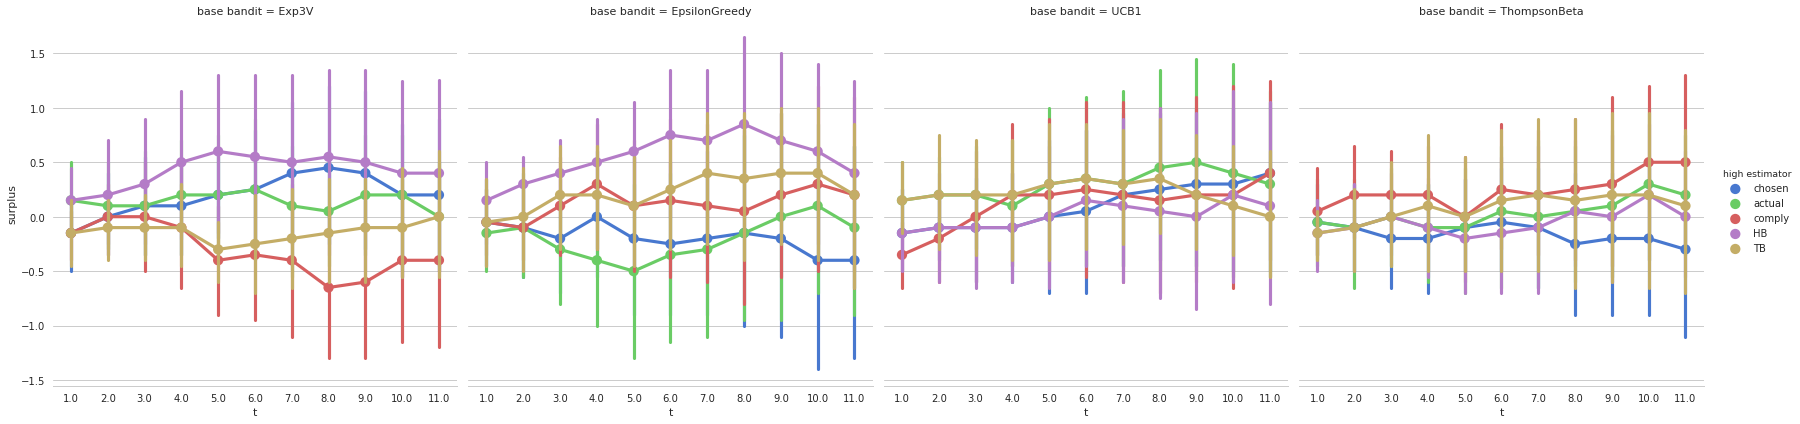

In [0]:

g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=example3,
                   size=6, palette="muted", col="base bandit") #
g.despine(left=True)
g.savefig("figs/ex3.png")


In [0]:
#always or never takers. current simulation model is not rich enough for defiers, todo?
class IndependentNoncomplianceAndRewards():
    def __init__(self,foo):
        n_arms=2
        self.arm_value = 0.9+0.1*np.random.random(int(n_arms))
        # todo add effect_magnitude=1
        self.n_arms = n_arms
    def draw_subject(self):
        if random.random()<0.9: #compliers 
            r=[(i, random.binomial(1,self.arm_value[i])) for i in range(self.n_arms)]
        else:   #always takers
            actual = categorical_draw(self.arm_value)
            reward = random.binomial(1,self.arm_value[actual])
            r= [(actual, reward) for i in range(self.n_arms)]
        return r

    
example4= sim( nsim=100, T=10001, DGP=IndependentNoncomplianceAndRewards , drug="example")
#display_results(example4.loc[example4['t'] == 10000].drop('t',1))



In [0]:
g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=example4,
                   size=6, palette="muted", col="base bandit") #
g.despine(left=True)
g.savefig("figs/ex4.png")


In [0]:
#REMEMBER TO SET EXP3V appropiately before running this (TODO: document how the exp3 constant is set!)

class IndependentNoncomplianceAndRewards():
    def __init__(self,foo):
        n_arms=2
        self.arm_value = np.random.random(int(n_arms))
        # todo add effect_magnitude=1
        self.n_arms = n_arms
    def draw_subject(self):
        if random.random()>0.5: #compliers 
            r=[(i, random.binomial(1,self.arm_value[i])) for i in range(self.n_arms)]
        else:   #always takers
            actual = categorical_draw(self.arm_value)
            reward = random.binomial(1,self.arm_value[actual])
            r= [(actual, reward) for i in range(self.n_arms)]
        return r



def sim_wrap3(x):
    return sim( nsim=10, T=12, DGP=IndependentNoncomplianceAndRewards , drug="example")

example5 = pd.DataFrame(columns=['base bandit','high estimator',"surplus",'drug','t'])

for x in range(100):
    with Pool(4) as p: #how many cores do we wan to use
        t0 = time.time()
        partial_results=(p.map(sim_wrap3,[1]))
        t1 = time.time()
        print('{}s, done: {}'.format(t1-t0, x))
    for p in partial_results:
        example5 = pd.concat([p,example5] )
        
display_results(example5.loc[example5['t'] == 11].drop('t',1))




2.276732921600342s, done: 0
2.2722020149230957s, done: 1
2.2753143310546875s, done: 2
2.2669448852539062s, done: 3
2.2651193141937256s, done: 4
2.270484685897827s, done: 5
2.275580644607544s, done: 6
2.2651703357696533s, done: 7
2.27300763130188s, done: 8
2.2699735164642334s, done: 9
2.2709085941314697s, done: 10
2.266230344772339s, done: 11
2.595463752746582s, done: 12
2.2721073627471924s, done: 13
2.274412155151367s, done: 14
2.275860548019409s, done: 15
2.269209861755371s, done: 16
2.27262806892395s, done: 17
2.2680246829986572s, done: 18
2.270279884338379s, done: 19
2.268195867538452s, done: 20
2.272080421447754s, done: 21
2.266798973083496s, done: 22
2.2651004791259766s, done: 23
2.272847890853882s, done: 24
2.2711164951324463s, done: 25
2.2621428966522217s, done: 26
2.2680418491363525s, done: 27
2.2711493968963623s, done: 28
2.2711634635925293s, done: 29
2.263787269592285s, done: 30
2.3029770851135254s, done: 31
2.266598701477051s, done: 32
2.2788379192352295s, done: 33
2.2671918

surplus                             \
                           mean median amin amax       std   
drug    base bandit                                          
example EpsilonGreedy  0.273667    0.0 -3.0  4.0  0.808206   
        Exp3V          0.018778    0.0 -3.5  4.0  0.808678   
        ThompsonBeta   0.400778    0.0 -3.5  4.0  0.934026   
        UCB1           0.192778    0.0 -3.5  3.5  0.825994   

                                                                     
                                                                 ci  
drug    base bandit                                                  
example EpsilonGreedy    (0.25033333333333335, 0.29777777777777775)  
        Exp3V          (-0.004555555555555556, 0.04211111111111111)  
        ThompsonBeta       (0.3731111111111111, 0.4275555555555556)  
        UCB1              (0.1688888888888889, 0.21755555555555556)

surplus                             \
                            mean median amin amax       std   
drug    high estimator                                        
example HB              0.195000    0.0 -3.5  4.0  0.820363   
        TB              0.258611    0.0 -3.5  4.0  0.929471   
        actual          0.290556    0.0 -3.5  4.0  0.863910   
        chosen          0.138611    0.0 -3.5  3.5  0.791352   
        comply          0.224722    0.0 -3.0  4.0  0.866178   

                                                                    
                                                                ci  
drug    high estimator                                              
example HB              (0.16847222222222222, 0.22194444444444444)  
        TB              (0.22847222222222222, 0.28930555555555554)  
        actual           (0.26208333333333333, 0.3194444444444444)  
        chosen          (0.11305555555555556, 0.16486111111111112)  
        comply           (0.1963888888888889, 0.25458333333333333)

surplus                             \
                                          mean median amin amax       std   
drug    high estimator base bandit                                          
example HB             EpsilonGreedy  0.245000    0.0 -1.5  3.0  0.757409   
                       Exp3V         -0.005000    0.0 -2.5  3.0  0.778413   
                       ThompsonBeta   0.353889    0.0 -3.5  4.0  0.916440   
                       UCB1           0.186111    0.0 -2.0  3.5  0.779019   
        TB             EpsilonGreedy  0.291667    0.0 -3.0  4.0  0.970756   
                       Exp3V          0.152778    0.0 -3.5  4.0  0.888527   
                       ThompsonBeta   0.405000    0.0 -3.0  3.5  0.943998   
                       UCB1           0.185000    0.0 -3.5  3.5  0.892402   
        actual         EpsilonGreedy  0.430556    0.5 -1.5  2.5  0.655184   
                       Exp3V          0.002778    0.0 -3.5  3.5  0.815413   
                       ThompsonBeta   0.548333    0.5 -2.0  4.0  0.967289   
                       UCB1           0.180556    0.0 -2.5  3.5  0.881405   
        chosen         EpsilonGreedy  0.119444    0.0 -3.0  2.0  0.692330   
                       Exp3V          0.040556    0.0 -3.5  3.0  0.769460   
                       ThompsonBeta   0.222778    0.0 -2.5  3.5  0.888114   
                       UCB1           0.171667    0.0 -2.5  3.0  0.792924   
        comply         EpsilonGreedy  0.281667    0.0 -2.5  3.5  0.891405   
                       Exp3V         -0.097222    0.0 -3.0  3.0  0.766544   
                       ThompsonBeta   0.473889    0.0 -2.0  4.0  0.921645   
                       UCB1           0.240556    0.0 -3.0  3.5  0.776225   

                                                                                    
                                                                                ci  
drug    high estimator base bandit                                                  
example HB             EpsilonGreedy     (0.19722222222222222, 0.2972222222222222)  
                       Exp3V           (-0.05611111111111111, 0.04555555555555556)  
                       ThompsonBeta     (0.29444444444444445, 0.41555555555555557)  
                       UCB1             (0.13555555555555557, 0.23555555555555555)  
        TB             EpsilonGreedy     (0.2288888888888889, 0.35444444444444445)  
                       Exp3V                           (0.09444444444444444, 0.21)  
                       ThompsonBeta      (0.3433333333333333, 0.46555555555555556)  
                       UCB1             (0.12777777777777777, 0.24444444444444444)  
        actual         EpsilonGreedy     (0.38722222222222225, 0.4738888888888889)  
                       Exp3V          (-0.051666666666666666, 0.05388888888888889)  
                       ThompsonBeta       (0.4861111111111111, 0.6116666666666667)  
                       UCB1             (0.12444444444444444, 0.23944444444444443)  
        chosen         EpsilonGreedy    (0.07388888888888889, 0.16444444444444445)  
                       Exp3V                         (-0.010555555555555556, 0.09)  
                       ThompsonBeta      (0.16555555555555557, 0.2811111111111111)  
                       UCB1             (0.11944444444444445, 0.22333333333333333)  
        comply         EpsilonGreedy    (0.22333333333333333, 0.33944444444444444)  
                       Exp3V          (-0.14777777777777779, -0.04888888888888889)  
                       ThompsonBeta      (0.41388888888888886, 0.5344444444444445)  
                       UCB1             (0.19055555555555556, 0.29055555555555557)

surplus                             \
                                  mean median amin amax       std   
high estimator base bandit                                          
HB             EpsilonGreedy  0.245000    0.0 -1.5  3.0  0.757409   
               Exp3V         -0.005000    0.0 -2.5  3.0  0.778413   
               ThompsonBeta   0.353889    0.0 -3.5  4.0  0.916440   
               UCB1           0.186111    0.0 -2.0  3.5  0.779019   
TB             EpsilonGreedy  0.291667    0.0 -3.0  4.0  0.970756   
               Exp3V          0.152778    0.0 -3.5  4.0  0.888527   
               ThompsonBeta   0.405000    0.0 -3.0  3.5  0.943998   
               UCB1           0.185000    0.0 -3.5  3.5  0.892402   
actual         EpsilonGreedy  0.430556    0.5 -1.5  2.5  0.655184   
               Exp3V          0.002778    0.0 -3.5  3.5  0.815413   
               ThompsonBeta   0.548333    0.5 -2.0  4.0  0.967289   
               UCB1           0.180556    0.0 -2.5  3.5  0.881405   
chosen         EpsilonGreedy  0.119444    0.0 -3.0  2.0  0.692330   
               Exp3V          0.040556    0.0 -3.5  3.0  0.769460   
               ThompsonBeta   0.222778    0.0 -2.5  3.5  0.888114   
               UCB1           0.171667    0.0 -2.5  3.0  0.792924   
comply         EpsilonGreedy  0.281667    0.0 -2.5  3.5  0.891405   
               Exp3V         -0.097222    0.0 -3.0  3.0  0.766544   
               ThompsonBeta   0.473889    0.0 -2.0  4.0  0.921645   
               UCB1           0.240556    0.0 -3.0  3.5  0.776225   

                                                                            
                                                                        ci  
high estimator base bandit                                                  
HB             EpsilonGreedy                  (0.19555555555555557, 0.295)  
               Exp3V           (-0.05611111111111111, 0.04555555555555556)  
               ThompsonBeta      (0.2916666666666667, 0.41055555555555556)  
               UCB1             (0.13666666666666666, 0.23666666666666666)  
TB             EpsilonGreedy    (0.22944444444444445, 0.35555555555555557)  
               Exp3V                           (0.095, 0.2111111111111111)  
               ThompsonBeta      (0.34444444444444444, 0.4677777777777778)  
               UCB1              (0.12777777777777777, 0.2461111111111111)  
actual         EpsilonGreedy      (0.3877777777777778, 0.4727777777777778)  
               Exp3V          (-0.050555555555555555, 0.05611111111111111)  
               ThompsonBeta       (0.4866666666666667, 0.6105555555555555)  
               UCB1             (0.12333333333333334, 0.23944444444444443)  
chosen         EpsilonGreedy    (0.07444444444444444, 0.16444444444444445)  
               Exp3V          (-0.008333333333333333, 0.09166666666666666)  
               ThompsonBeta      (0.16444444444444445, 0.2811111111111111)  
               UCB1                             (0.12, 0.2238888888888889)  
comply         EpsilonGreedy     (0.2222222222222222, 0.33944444444444444)  
               Exp3V          (-0.14722222222222223, -0.04777777777777778)  
               ThompsonBeta      (0.41444444444444445, 0.5361111111111111)  
               UCB1                            (0.19, 0.29333333333333333)

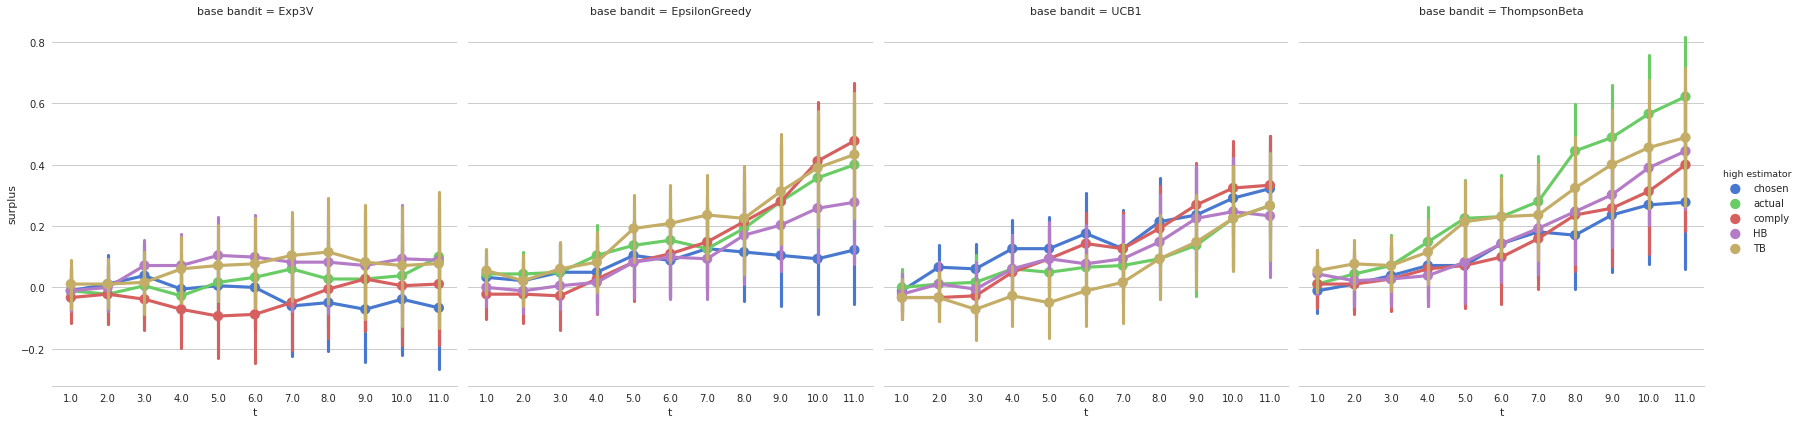

In [0]:
g = sns.factorplot(x='t', y="surplus", hue="high estimator", data=example5,
                   size=6, palette="muted", col="base bandit") #
g.despine(left=True)

example5.to_csv("independent non compliant reward.csv")